In [24]:
import pandas as pd
import pickle 
import numpy as np
import networkx as nx
import re

ROOT_PATH = '/home/chiwon/workspace/vmh_workbook/mangoflavoured.github.io'
graphs = ["Colorectal", "IBD", "Obesity", "T2D", "WT2D"] #Cirrhosis: error

In [34]:
with open(f"{ROOT_PATH}/data/mm-graph/preprocessed_T2D.pkl", "rb") as h:
    t2d_dict = pickle.load(h)
    print(t2d_dict.keys())

dict_keys(['abundance_profile', 'marker_profile', 'microbe_names', 'fold_idx_1', 'fold_idx_2', 'fold_idx_3', 'fold_idx_4', 'fold_idx_5'])


In [35]:
for key in col_dict.keys():
    print(type(col_dict[key]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


In [37]:
t2d_abundance = pd.DataFrame(t2d_dict["abundance_profile"])
t2d_marker = pd.DataFrame(t2d_dict["marker_profile"])
t2d_abundance.to_csv(f"{ROOT_PATH}/data/mm-graph/T2D_Abundance_Profile.csv")
t2d_marker.to_csv(f"{ROOT_PATH}/data/mm-graph/T2D_Marker_Profile.csv")

In [38]:
t2d_marker.shape

(344, 120001)

In [50]:
t2d_marker.head()

dataset_name,ID@subjectID,CLI@bodysite,Y@disease,CLI@age,CLI@gender,CLI@country,CLI@sequencing_technology,CLI@pubmedid,CLI@camp,CLI@paired_end_insert_size,...,X@gi|83286007|ref|XM_724880.1|,X@gi|83591340|ref|NC_007643.1|:3854287-3855165,X@gi|83956146|ref|NZ_AALZ01000014.1|:c71868-71287,X@gi|84389706|ref|NZ_AAMR01000024.1|:c62016-61705,X@gi|85057280|ref|NC_007716.1|:178414-178599,X@gi|85057280|ref|NC_007716.1|:195234-195935,X@gi|88607955|ref|NC_007798.1|:118090-119082,X@gi|88797415|ref|NZ_AAOE01000002.1|:c235147-234506,X@gi|89892746|ref|NC_007907.1|:c3938880-3937900,X@gi|94502223|ref|NZ_AANL01000001.1|:c8848-8444
ID@sampleID,,,,,,,,,,,,,,,,,,,,,
CON-001,con-001,stool,n,21,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-002,con-002,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-003,con-003,stool,n,61,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-004,con-004,stool,n,55,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-005,con-005,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#checking duplicates
column_list = list(t2d_marker.columns)
column_set = set(column_list)
print(len(list(column_set)) == len(column_list))

True


In [49]:
#overall sparsity of microbes
t2d_marker_filtered = t2d_marker.filter(regex = "^X@gi")
t2d_marker_filtered = t2d_marker_filtered.astype(int)
t2d_matrix = t2d_marker_filtered.to_numpy()
print("SPARSITY: {}".format((t2d_matrix ==0).mean()))

SPARSITY: 0.8880357251018044


In [54]:
#label counts
label_count = len(t2d_marker)
label_false = t2d_marker.loc[t2d_marker["Y@disease"] == "n"]
false_count = len(label_false)
true_count = label_count - false_count

print(f"TOTAL: {label_count}\nTRUE_NEG: {false_count}\nTRUE:POS: {true_count}")

TOTAL: 344
TRUE_NEG: 174
TRUE:POS: 170


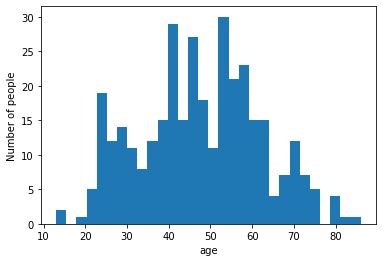

mean age:47.526162790697676


In [57]:
#age distribution
import matplotlib.pyplot as plt
age_list = list(t2d_marker["CLI@age"].astype(int))
n_bins=30
plt.hist(age_list, n_bins)
plt.xlabel("age")
plt.ylabel("Number of people")
plt.show()
print(f"mean age:{np.array(age_list).mean()}")